# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [1]:
# import keras
from tensorflow import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(y_train.shape[0], -1)
x_test = x_test_pics.reshape(y_test.shape[0], -1)

In [2]:
# check
x_train.shape, y_train.shape

((60000, 784), (60000,))

__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [3]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")

In [4]:
# graphics
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.scale import LogScale

plt.rcParams.update({'font.size': 18})
sns.set_style('whitegrid')
sns.set(style='darkgrid', palette='deep')

plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
plt.rcParams['savefig.format'] = 'pdf'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin


class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.pca = PCA(n_components=self.new_dim)
        
    def fit(self, X, y, train_mode=True):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.

        train_mode, bool: use strategy: train or test
        """
        if self.use_PCA:
            if train_mode:
                X = self.pca.fit_transform(X)
            else:
                X = self.pca.transform(X)
        else:
            self.new_dim = X.shape[1]  # если не используем PCA, то размерность не меняется

        if train_mode:
            # считаем сигму
            idx_1 = np.random.randint(0, y.shape[0], 1_000_000) # индексы для 1 части пар
            idx_2 = np.random.randint(0, y.shape[0], 1_000_000) # индексы для 2 части пар

            X_sub_1 = X[idx_1]  # подвыборка для 1 части пар
            X_sub_2 = X[idx_2]  # подвыборка для 2 части пар

            # считаем векторизованно
            self.sigma = np.sqrt(np.median(np.sum((X_sub_1 - X_sub_2) ** 2, axis=(1))))

            # генерируем наборы весов и сдвигов
            self.w = np.random.normal(0, (1/self.sigma), size=(self.n_features, self.new_dim))
            self.b = np.random.uniform(-np.pi, np.pi, size=self.n_features)
            
            # формируем новые признаки
            self.train_Random_Fourier_Features = np.cos(X@self.w.T + self.b)

            # обучение классификатора
            if self.classifier == 'logreg':
                self.classif = LogisticRegression(max_iter=1000, n_jobs=-1)  # по умолч. max_iter=100
            elif self.classifier == 'svm':
                # self.classif = SVC(kernel='linear', probability=True)
                self.classif = LinearSVC()                                   # по умолч. max_iter=1000
            else:
                assert False, 'Указанный классификатор не поддерживается'
                
            self.classif.fit(self.train_Random_Fourier_Features, y)

        else:
            self.test_Random_Fourier_Features = np.cos(X@self.w.T + self.b)  # если инференс, статистики не меняются, веса и сдвиги сгенерированы

        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        y_pred_proba = self.classif.predict_proba(X)  # чтобы метод работал, нужно поменять LinearSVC на SVC(kernel='linear', probability=True)

        return y_pred_proba
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        y_pred = self.classif.predict(X)
        
        return y_pred

*Примечание:* из-за необходимости предобработки данных (PCA, формирование новых признаков) в методе `.fit()` я реализовал развилку для использования пайплайна для обучения и инференса. Если выставить флаг `train_mode`, в процессе обучения будут расчитаны все необходимые статистики и произведена генерация новых весов $w_j$ и сдвигов $b_j$, а также будет обучен классификатор. Иначе будет произведена только предобработка данных на основе рассчитанных ранее статистик, чтобы оценить "истинное" качество модели. 

Протестируем решение. Посчитаем метрику **accuracy** на трейне и на тесте.

In [14]:
# обучение
rff = RFFPipeline(classifier='logreg')
rff.fit(x_train, y_train, train_mode=True)

RFFPipeline()

In [15]:
y_pred_train = rff.predict(rff.train_Random_Fourier_Features)
acc_train = accuracy_score(y_train, y_pred_train)

# обработка данных для теста
rff.fit(x_test, y_test, train_mode=False)
y_pred_test = rff.predict(rff.test_Random_Fourier_Features)
acc_test = accuracy_score(y_test, y_pred_test)

print(f'Качество на трейне составило: {round(acc_train, 4)} \
    \nКачество на тесте составило: {round(acc_test, 4)}')

Качество на трейне составило: 0.9122     
Качество на тесте составило: 0.88


In [14]:
# dataframe для сравнения 
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['Исходные признаки', 
                                   'PCA',
                                   'RFF',
                                   'PCA & RFF'])

# добавление очередной строки с характеристиками метода
df_metrics.loc['LogReg'] = [
    None,
    None,
    None,
    0.8800
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

Исходные признаки  PCA  RFF  PCA & RFF
LogReg                NaN  NaN  NaN       0.88

Теперь проверим работу **SVM**:

In [17]:
rff = RFFPipeline(classifier='svm')
rff.fit(x_train, y_train, train_mode=True)

RFFPipeline(classifier='svm')

In [18]:
y_pred_train = rff.predict(rff.train_Random_Fourier_Features)
acc_train = accuracy_score(y_train, y_pred_train)

# обработка данных для теста
rff.fit(x_test, y_test, train_mode=False)
y_pred_test = rff.predict(rff.test_Random_Fourier_Features)
acc_test = accuracy_score(y_test, y_pred_test)

print(f'Качество на трейне составило: {round(acc_train, 4)}\
     \nКачество на тесте составило: {round(acc_test, 4)}')

Качество на трейне составило: 0.9084     
Качество на тесте составило: 0.8757


In [15]:
df_metrics.loc['Linear SVM'] = [
    None,
    None,
    None,
    0.8757
]

df_metrics

Исходные признаки  PCA  RFF  PCA & RFF
LogReg                    NaN  NaN  NaN     0.8800
Linear SVM                NaN  NaN  NaN     0.8757

Качество немного ниже, а обучался SVM в два раза дольше дольше (почти 7 мин. против 3).

Для обоих линейных классификаторов бейзлайн ($accuracy \ge 0.84$) был преодолен. При этом оба классификатора не сошлись и достигли `max_iter` — возможно, из-за того, что у данных очень разный масштаб после PCA (хотя косинус все равно вытягивает их на отрезок от -1 до 1). При этом "отсечка" на разницу градиента между шагами и т.д. на срабатывает, значит, обе модели еще не достигают оптимума*.

*прим.: это на самом деле так: по умолчанию у логистической регрессии стоит 100 итераций (на которых она тоже не сходилась). При увеличении макс. числа итераций для нее со 100 до 1000 качество увеличилось примерно на 0.05 в терминах accuracy, но модель все еще не сошлась.

__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

*Сравнение подхода со случайными признаками с обучением SVM на исходных признаках:*

In [36]:
lin_smv = LinearSVC()
lin_smv.fit(x_train, y_train)

c:\Users\Admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [37]:
# трейн
y_pred_train = lin_smv.predict(x_train)
acc_train = accuracy_score(y_train, y_pred_train)

# тест
y_pred_test = lin_smv.predict(x_test)
acc_test = accuracy_score(y_test, y_pred_test)

print(f'Качество на трейне составило: {round(acc_train, 4)}\
     \nКачество на тесте составило: {round(acc_test, 4)}')

Качество на трейне составило: 0.7475     
Качество на тесте составило: 0.7205


In [16]:
df_metrics.loc['Linear SVM']['Исходные признаки'] = 0.7205
df_metrics

Исходные признаки  PCA  RFF  PCA & RFF
LogReg                    NaN  NaN  NaN     0.8800
Linear SVM             0.7205  NaN  NaN     0.8757

В качестве эксперимента попробую **отмасштабировать данные** перед применением линейного SMV:

In [15]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [16]:
lin_smv = LinearSVC(max_iter=100)
lin_smv.fit(x_train_scaled, y_train)

c:\Users\Admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(max_iter=100)

In [17]:
# трейн
y_pred_train = lin_smv.predict(x_train)
acc_train = accuracy_score(y_train, y_pred_train)

# тест
y_pred_test = lin_smv.predict(x_test)
acc_test = accuracy_score(y_test, y_pred_test)

print(f'Качество на трейне составило: {round(acc_train, 4)}\
     \nКачество на тесте составило: {round(acc_test, 4)}')

Качество на трейне составило: 0.6614     
Качество на тесте составило: 0.6391


Получилось хуже.

Теперь попробуем логистическую регрессию:

In [10]:
log_reg = LogisticRegression(max_iter=1000, n_jobs=-1)
log_reg.fit(x_train, y_train)

LogisticRegression(max_iter=1000, n_jobs=-1)

In [11]:
# трейн
y_pred_train = log_reg.predict(x_train)
acc_train = accuracy_score(y_train, y_pred_train)

# тест
y_pred_test = log_reg.predict(x_test)
acc_test = accuracy_score(y_test, y_pred_test)

print(f'Качество на трейне составило: {round(acc_train, 4)}\
     \nКачество на тесте составило: {round(acc_test, 4)}')

Качество на трейне составило: 0.8795     
Качество на тесте составило: 0.832


In [17]:
df_metrics.loc['LogReg']['Исходные признаки'] = 0.8320
df_metrics

Исходные признаки  PCA  RFF  PCA & RFF
LogReg                 0.8320  NaN  NaN     0.8800
Linear SVM             0.7205  NaN  NaN     0.8757

У логистической регрессии качество на исходных признаках получилось заметно лучше (и быстрее: 3 мин. VS 5 мин.).

Вывод: *линейный SVM справляется с задачей на исходных данных хуже (примерно на 0.15 в терминах accuracy), чем при использовании случайных нелинейных признаков*. Думаю, что это можно объяснить тем, что:
1. мы работаем с картинками и фактически вытягиваем их в векторы. Строить поверх линейную модель непрактично с т.з. методов Computer Vision — небольшое изменение пикселей (картинки) приведет к неправильному результату;
2. изначальная размерность (784) слишком большая и одновременно сложная для того, чтобы получить высокое качество на линейной модели. Но, вероятно, если посчитать новые признаки в каком-то более сложном пространстве, линейной модели будет намного проще.

При этом логистическая регрессия справилась с задачей классификации по исходным признакам гораздо лучше и быстрее, чем линейный SVM (но все еще хуже варианта PCA + RFF), а по времени — так же.

*Сравнение подхода со случайными признаками с обучением **ядрового** SVM на исходных признаках:*

In [60]:
idx = np.random.randint(0, y_train.shape[0], 30_000)  # берем случайное подмножество из половины объектов обучающей выборки

In [61]:
kernel_svm = SVC()
kernel_svm.fit(x_train[idx], y_train[idx])

SVC()

In [63]:
# трейн
y_pred_train = kernel_svm.predict(x_train[idx])
acc_train = accuracy_score(y_train[idx], y_pred_train)

# тест
y_pred_test = kernel_svm.predict(x_test)
acc_test = accuracy_score(y_test, y_pred_test)

print(f'Качество на трейне составило: {round(acc_train, 4)}\
     \nКачество на тесте составило: {round(acc_test, 4)}')

Качество на трейне составило: 0.9159     
Качество на тесте составило: 0.8703


**Вывод:** при обучении на подмножестве из половины выборки (30 000) ядровой SVM достиг лучшего качества на трейне (0.9159 VS 0.9056) и практически такого же качества на тесте (0.8703 VS 0.8757), при этом (хотя и на подмножестве объектов) он обучался гораздо быстрее, чем линейный SVM.
Возможно, это произошло из-за того, что линейный SVM не сходился и достигал `max_iter` (по умолч. у ядрового SVM нет ограничения на него).

Однако на применении ядровой SVM работал очень долго — 5 минут. Вероятно из-за того, что ему нужно было посчитать скалярные произведения в более сложном пространстве для тестовой выборки.

Попробую обучить ядровой SVM на всем изначальном наборе данных:

In [64]:
kernel_svm = SVC()
kernel_svm.fit(x_train, y_train)

SVC()

In [65]:
# трейн
y_pred_train = kernel_svm.predict(x_train)
acc_train = accuracy_score(y_train, y_pred_train)

# тест
y_pred_test = kernel_svm.predict(x_test)
acc_test = accuracy_score(y_test, y_pred_test)

print(f'Качество на трейне составило: {round(acc_train, 4)}\
     \nКачество на тесте составило: {round(acc_test, 4)}')

Качество на трейне составило: 0.9117     
Качество на тесте составило: 0.8828


In [18]:
df_metrics.loc['Kernel SVM'] = [
    0.8828,
    None,
    None,
    None
]

df_metrics

Исходные признаки  PCA  RFF  PCA & RFF
LogReg                 0.8320  NaN  NaN     0.8800
Linear SVM             0.7205  NaN  NaN     0.8757
Kernel SVM             0.8828  NaN  NaN        NaN

Качество на трейне осталось таким же (высоким), а на тесте — увеличилось и превзошло вариант со случайными признаками (0.8828 VS 0.8757). Обучался ядровой SVM примерно столько же, сколько линейный (который не сошелся), однако *применялся очень долго*: 17 минут.

*Сравнение с понижением размерности с помощью PCA и обучением градиентного бустинга.*

Бейзлайн без подбора гиперпараметров:

In [9]:
pca = PCA(n_components=50)

x_train_reduced = pca.fit_transform(x_train)
x_test_reduced = pca.transform(x_test)

In [26]:
model = CatBoostClassifier(iterations=1000,
                           task_type="GPU",
                           devices='0:1',
                           custom_loss='Accuracy',
                           train_dir='model-1')
model.fit(x_train_reduced,
          y_train,
          verbose=100,
          use_best_model=True,
          eval_set=(x_test_reduced, y_test),
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.15901
0:	learn: 1.7825036	test: 1.7893209	best: 1.7893209 (0)	total: 26.5ms	remaining: 26.5s
100:	learn: 0.3606648	test: 0.4302363	best: 0.4302363 (100)	total: 2.04s	remaining: 18.2s
200:	learn: 0.2849197	test: 0.3859226	best: 0.3859226 (200)	total: 4.03s	remaining: 16s
300:	learn: 0.2416471	test: 0.3683026	best: 0.3683026 (300)	total: 5.99s	remaining: 13.9s
400:	learn: 0.2114484	test: 0.3570709	best: 0.3570709 (400)	total: 7.97s	remaining: 11.9s
500:	learn: 0.1856747	test: 0.3491199	best: 0.3491199 (500)	total: 9.98s	remaining: 9.94s
600:	learn: 0.1644758	test: 0.3439454	best: 0.3439454 (600)	total: 12s	remaining: 7.94s
700:	learn: 0.1459217	test: 0.3400251	best: 0.3400251 (700)	total: 14s	remaining: 5.96s
800:	learn: 0.1302064	test: 0.3372895	best: 0.3372085 (795)	total: 16s	remaining: 3.98s
900:	learn: 0.1164816	test: 0.3350597	best: 0.3349707 (890)	total: 18s	remaining: 1.97s
999:	learn: 0.1049914	test: 0.3334260	best: 0.3333334 (986)	total: 20s	remaining: 0u

In [27]:
# трейн
y_pred_train = model.predict(x_train_reduced)
acc_train = accuracy_score(y_train, y_pred_train)

# тест
y_pred_test = model.predict(x_test_reduced)
acc_test = accuracy_score(y_test, y_pred_test)

print(f'Качество на трейне составило: {round(acc_train, 4)}\
     \nКачество на тесте составило: {round(acc_test, 4)}')

Качество на трейне составило: 0.9807     
Качество на тесте составило: 0.8792


Сразу очень хороший результат: 0.9807 на трейне (против 0.9117) и 0.8792 на тесте (против 0.8828) у ядрового SVM.

При этом обучается на GPU очень быстро (около 20 сек.), а применяется почти моментально.

Попробуем подобрать гиперпараметры.

In [18]:
grid = {'iterations' : [128, 256, 512, 1024],
        'learning_rate': [0.03, 0.1, 0.15],
        'depth': [4, 6, 10]}

In [19]:
model = CatBoostClassifier(task_type="GPU",
                           devices='0:1',
                           custom_loss='Accuracy')

grid_search_result = model.grid_search(grid,
                                       x_train_reduced, 
                                       y_train, 
                                       verbose=False,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

bestTest = 0.7596813965
bestIteration = 127
bestTest = 0.4911444499
bestIteration = 127
bestTest = 0.4467259928
bestIteration = 127
bestTest = 0.5762822673
bestIteration = 255
bestTest = 0.4197547607
bestIteration = 255
bestTest = 0.3947943929
bestIteration = 255
bestTest = 0.4672252604
bestIteration = 511
bestTest = 0.3779526774
bestIteration = 511
bestTest = 0.3629377035
bestIteration = 511
bestTest = 0.4056690674
bestIteration = 1023
bestTest = 0.3499822184
bestIteration = 1023
bestTest = 0.3399385173
bestIteration = 1023
bestTest = 0.6267048747
bestIteration = 127
bestTest = 0.4288378499
bestIteration = 127
bestTest = 0.3984937337
bestIteration = 127
bestTest = 0.486359904
bestIteration = 255
bestTest = 0.3789730225
bestIteration = 255
bestTest = 0.3606073405
bestIteration = 255
bestTest = 0.4107859294
bestIteration = 511
bestTest = 0.3450280355
bestIteration = 511
bestTest = 0.3333116048
bestIteration = 511
bestTest = 0.3663847656
bestIteration = 1023
bestTest = 0.3221322835
bestI

In [20]:
grid_search_result['params']

{'depth': 6, 'iterations': 1024, 'learning_rate': 0.15}

In [21]:
# трейн
y_pred_train = model.predict(x_train_reduced)
acc_train = accuracy_score(y_train, y_pred_train)

# тест
y_pred_test = model.predict(x_test_reduced)
acc_test = accuracy_score(y_test, y_pred_test)

print(f'Качество на трейне составило: {round(acc_train, 4)}\
     \nКачество на тесте составило: {round(acc_test, 4)}')

Качество на трейне составило: 0.9808     
Качество на тесте составило: 0.8777


Почти все параметры совпали c теми, которые стоят по умолчанию, а качество на тесте стало немного меньше.

Попробуем подобрать коэф-т регуляризации `l2_leaf_reg` и `learning_rate` (по умолчанию он подбирается автоматически).

In [29]:
grid = {'l2_leaf_reg': [1, 3, 5, 7, 9],
        'learning_rate': [0.03, 0.1, 0.12, 0.14, 0.15, 0.16, 0.18]}

In [30]:
model = CatBoostClassifier(iterations=1024,
                           task_type="GPU",
                           devices='0:1',
                           custom_loss='Accuracy')

grid_search_result = model.grid_search(grid,
                                       x_train_reduced, 
                                       y_train, 
                                       verbose=False,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

bestTest = 0.357870931
bestIteration = 1023
bestTest = 0.3203320719
bestIteration = 1023
bestTest = 0.3203340658
bestIteration = 941
bestTest = 0.3229194743
bestIteration = 942
bestTest = 0.3202311401
bestIteration = 970
bestTest = 0.3258506673
bestIteration = 789
bestTest = 0.3260488281
bestIteration = 747
bestTest = 0.366641154
bestIteration = 1023
bestTest = 0.3221323039
bestIteration = 1023
bestTest = 0.3196836548
bestIteration = 1023
bestTest = 0.3198910929
bestIteration = 1022
bestTest = 0.3200292765
bestIteration = 1022
bestTest = 0.3226994425
bestIteration = 1011
bestTest = 0.320962443
bestIteration = 953
bestTest = 0.3703534342
bestIteration = 1023
bestTest = 0.326205424
bestIteration = 1023
bestTest = 0.3226364543
bestIteration = 1023
bestTest = 0.3193103841
bestIteration = 1023
bestTest = 0.3230153198
bestIteration = 1023
bestTest = 0.3214509888
bestIteration = 1023
bestTest = 0.3218519287
bestIteration = 1018
bestTest = 0.3742081706
bestIteration = 1023
bestTest = 0.3293043

In [31]:
grid_search_result['params']

{'l2_leaf_reg': 5, 'learning_rate': 0.14}

In [32]:
# трейн
y_pred_train = model.predict(x_train_reduced)
acc_train = accuracy_score(y_train, y_pred_train)

# тест
y_pred_test = model.predict(x_test_reduced)
acc_test = accuracy_score(y_test, y_pred_test)

print(f'Качество на трейне составило: {round(acc_train, 4)}\
     \nКачество на тесте составило: {round(acc_test, 4)}')

Качество на трейне составило: 0.9691     
Качество на тесте составило: 0.8778


В результате первое применение без подбора гиперпараметров все равно оказалось лучше. Запишем его в таблицу.

In [19]:
df_metrics.loc['CatBoostClassifier'] = [
    None,
    0.8792,
    None,
    None
]

df_metrics

Исходные признаки     PCA  RFF  PCA & RFF
LogReg                         0.8320     NaN  NaN     0.8800
Linear SVM                     0.7205     NaN  NaN     0.8757
Kernel SVM                     0.8828     NaN  NaN        NaN
CatBoostClassifier                NaN  0.8792  NaN        NaN

**Общий вывод:**
* Случайные признаки — мощная идея. Логистическая регрессия работает с ними качественнее, чем Линейный SVM (в дальнейших экспериментах будет выявлено, что при определенных условиях они выдают одинаковый по качеству результат) и бысрее. При этом обе линейные модели не сходятся за 1000 итераций.
* Линейный SVM работает плохо на исходных данных — это логично, учитывая, что мы подаем ему ч/б картинки, вытянутые в вектор — размерность данных получается 784. Предварительное масштабирование данных только ухудшает результат. Логистическая регрессия же работает на исходных данных гораздо лучше, но все равно не достигает результата с PCA & RFF.
* Ядровой SVM работает очень хорошо на исходных данных — видимо в более сложном пространстве данные не так сложно разделить.
    * было предпринято несколько попыток обучения ядрового SVM на разных подмножествах исходной выборки (30к, 48к, 60к из 60к)
    * ядровой SVM даже на всей выборке обучается примерно столько же, сколько линейный (который не сходится — возможно дело в этом) — около 5 минут, однако применяется ядровой SVM бесконечно долго — около 10 минут на тестовой выборке из 10к и 17-20 минут на обучающей + тестовой.
* Градиентный бустинг с предварительным понижением размерности через PCA обучается очень быстро (20 сек. на GPU) в силу качественной реализации фреймворка. Применяется практически тоже очень быстро.
    * я бы назвал его "ленивым" вариантом, потому что град. бустинг показал лучшее качество с гиперпараметрами по умолчанию с первого запуска. Это качество практически идентично ядровому SVM — лучшему, которого пока что удалось достичь — не говоря уже о скорости применения (3 сек. VS 20 мин.);
    * ниже при применении град. бустинга к исходным данным будет получено лучшее качество из всех тестов (accuracy $\approx$ 0.89).

**Итог:** ядровой SVM показал лучший (пока) результат (причем на исходных данных). Если абстрагироваться от градиентного бустинга, у которого нет очевидных слабых сторон, RFF (случайные признаки + линейная модель) — отличный метод по ряду причин:
1. Относительно быстро учится и очень быстро применяется
    * фактически обучение начинается только на моменте обучения классификатора; до этого просто считаются матрицы.
2. Выдает качество, практически идентичное градиентному бустингу, за которым стоит большая инженерия.
3. Реализацию алгоритма точно можно дорабатывать, точнее часть с линейной моделью, т.к. как логистическая регрессия, так и лиенйный SVM не сходились (даже при увеличении числа итераций). Можно также пробовать подбирать гиперпараметры или поменять функцию потерь у линейных классификаторов.

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

*1. Помогает ли предварительное понижение размерности с помощью PCA?*

Сравним реализации подхода RFF с понижением размерности и без. 
В начале еще раз обучим RFF **с понижением размерности** до 50:

In [26]:
# с logreg
rff = RFFPipeline(classifier='logreg')
rff.fit(x_train, y_train, train_mode=True)

RFFPipeline()

In [27]:
y_pred_train = rff.predict(rff.train_Random_Fourier_Features)
acc_train = accuracy_score(y_train, y_pred_train)

# обработка данных для теста
rff.fit(x_test, y_test, train_mode=False)
y_pred_test = rff.predict(rff.test_Random_Fourier_Features)
acc_test = accuracy_score(y_test, y_pred_test)

print(f'Классификатор: логистическая регрессия \
    \nКачество на трейне составило: {round(acc_train, 4)} \
    \nКачество на тесте составило: {round(acc_test, 4)}')

Классификатор: логистическая регрессия     
Качество на трейне составило: 0.9139     
Качество на тесте составило: 0.8759


In [28]:
# с svm
rff = RFFPipeline(classifier='svm')
rff.fit(x_train, y_train, train_mode=True)

RFFPipeline(classifier='svm')

In [29]:
y_pred_train = rff.predict(rff.train_Random_Fourier_Features)
acc_train = accuracy_score(y_train, y_pred_train)

# обработка данных для теста
rff.fit(x_test, y_test, train_mode=False)
y_pred_test = rff.predict(rff.test_Random_Fourier_Features)
acc_test = accuracy_score(y_test, y_pred_test)

print(f'Классификатор: линейный SVM \
    \nКачество на трейне составило: {round(acc_train, 4)} \
    \nКачество на тесте составило: {round(acc_test, 4)}')

Классификатор: линейный SVM     
Качество на трейне составило: 0.9105     
Качество на тесте составило: 0.874


Теперь обучим RFF без понижения размерности:

In [7]:
# с logreg
x_train_32 = x_train.astype(np.float32)

rff = RFFPipeline(classifier='logreg', use_PCA=False)
rff.fit(x_train_32, y_train, train_mode=True)

RFFPipeline(new_dim=784, use_PCA=False)

In [8]:
x_test_32 = x_test.astype(np.float32)

y_pred_train = rff.predict(rff.train_Random_Fourier_Features)
acc_train = accuracy_score(y_train, y_pred_train)

# обработка данных для теста
rff.fit(x_test_32, y_test, train_mode=False)
y_pred_test = rff.predict(rff.test_Random_Fourier_Features)
acc_test = accuracy_score(y_test, y_pred_test)

print(f'Классификатор: логистическая регрессия \
    \nКачество на трейне составило: {round(acc_train, 4)} \
    \nКачество на тесте составило: {round(acc_test, 4)}')

Классификатор: логистическая регрессия     
Качество на трейне составило: 0.9191     
Качество на тесте составило: 0.866


In [9]:
# с svm
rff = RFFPipeline(classifier='svm', use_PCA=False)
rff.fit(x_train_32, y_train, train_mode=True)

RFFPipeline(classifier='svm', new_dim=784, use_PCA=False)

In [10]:
y_pred_train = rff.predict(rff.train_Random_Fourier_Features)
acc_train = accuracy_score(y_train, y_pred_train)

# обработка данных для теста
rff.fit(x_test_32, y_test, train_mode=False)
y_pred_test = rff.predict(rff.test_Random_Fourier_Features)
acc_test = accuracy_score(y_test, y_pred_test)

print(f'Классификатор: линейный SVM \
    \nКачество на трейне составило: {round(acc_train, 4)} \
    \nКачество на тесте составило: {round(acc_test, 4)}')

Классификатор: линейный SVM     
Качество на трейне составило: 0.8975     
Качество на тесте составило: 0.8561


In [11]:
# dataframe для сравнения 
# методов классификации по метрикам
df_exp1 = pd.DataFrame(columns=['RFF с PCA', 'RFF без PCA'])

df_exp1.loc['LogReg'] = [0.8759, 0.8660]
df_exp1.loc['Linear SVM'] = [0.8740, 0.8561]

df_exp1

RFF с PCA  RFF без PCA
LogReg         0.8759       0.8660
Linear SVM     0.8740       0.8561

Лагируем данные

In [20]:
df_metrics.loc['LogReg']['RFF'] = 0.8660
df_metrics.loc['Linear SVM']['RFF'] = 0.8561
df_metrics

Исходные признаки     PCA     RFF  PCA & RFF
LogReg                         0.8320     NaN  0.8660     0.8800
Linear SVM                     0.7205     NaN  0.8561     0.8757
Kernel SVM                     0.8828     NaN     NaN        NaN
CatBoostClassifier                NaN  0.8792     NaN        NaN

**Вывод:** да, помогает. Как для скорости обучения/применения, так и для итогового качества. Если не сокращать размерность, линейные модели дольше обучаются и выдают меньшее качество, а также тратят намного больше памяти. Кроме того, возможно, обучающая выборка относительно небольшая (60к объектов) для такого большого числа признаков и для относительно слабых линейных моделей. *Таким образом, я вижу использование RFF без PCA бессмысленным.*

*Интересный факт:* обучить RFF без PCA получилось не с первого раза. Если не переводить данные в более "точный" `np.float32`, модели "разваливались" и после долгого "обучения" выдавали результат на уровне случайного предсказания. Скорее всего, это происходило по причине overflow из-за недостаточно точного изначального типа данных, в котором хранится выборка. При этом при использовании `np.float64` мне не хватало памяти на ноутбуке (несмотря на то, что у него 16 гб оперативной памяти). Думаю, что overflow происходил на этапе подсчета сигмы, следовательно, генерировались плохие признаки.

*2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?*

Переберу 13 значений `n_features` по логарифмической шкале с основанием 2:

In [60]:
n_features = np.logspace(2, 14, 13, base=2.0, dtype=np.int64)
n_features

array([    4,     8,    16,    32,    64,   128,   256,   512,  1024,
        2048,  4096,  8192, 16384], dtype=int64)

In [ ]:
np.random.seed(13)  # фиксируем сид

acc_train_logreg = []
acc_test_logreg = []
acc_train_svm = []
acc_test_svm = []
i = 0

for n_feature in n_features:
    print(f'Тестирую n_feature = {n_features[i]}')

    # LogReg
    rff = RFFPipeline(classifier='logreg', n_features=n_feature)
    rff.fit(x_train, y_train, train_mode=True)
    
    y_pred_train = rff.predict(rff.train_Random_Fourier_Features)
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_train_logreg.append(acc_train)  # логируем

    rff.fit(x_test, y_test, train_mode=False)
    y_pred_test = rff.predict(rff.test_Random_Fourier_Features)
    acc_test = accuracy_score(y_test, y_pred_test)
    acc_test_logreg.append(acc_test)  # логируем


    # SVM
    rff = RFFPipeline(classifier='svm', n_features=n_feature)
    rff.fit(x_train, y_train, train_mode=True)

    y_pred_train = rff.predict(rff.train_Random_Fourier_Features)
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_train_svm.append(acc_train)  # логируем

    rff.fit(x_test, y_test, train_mode=False)
    y_pred_test = rff.predict(rff.test_Random_Fourier_Features)
    acc_test = accuracy_score(y_test, y_pred_test)
    acc_test_svm.append(acc_test)  # логируем

    i += 1

Прим.: SVM не смог обучиться с последним `n_features=16384` из-за нехватки памяти, но тренд будет понятен.

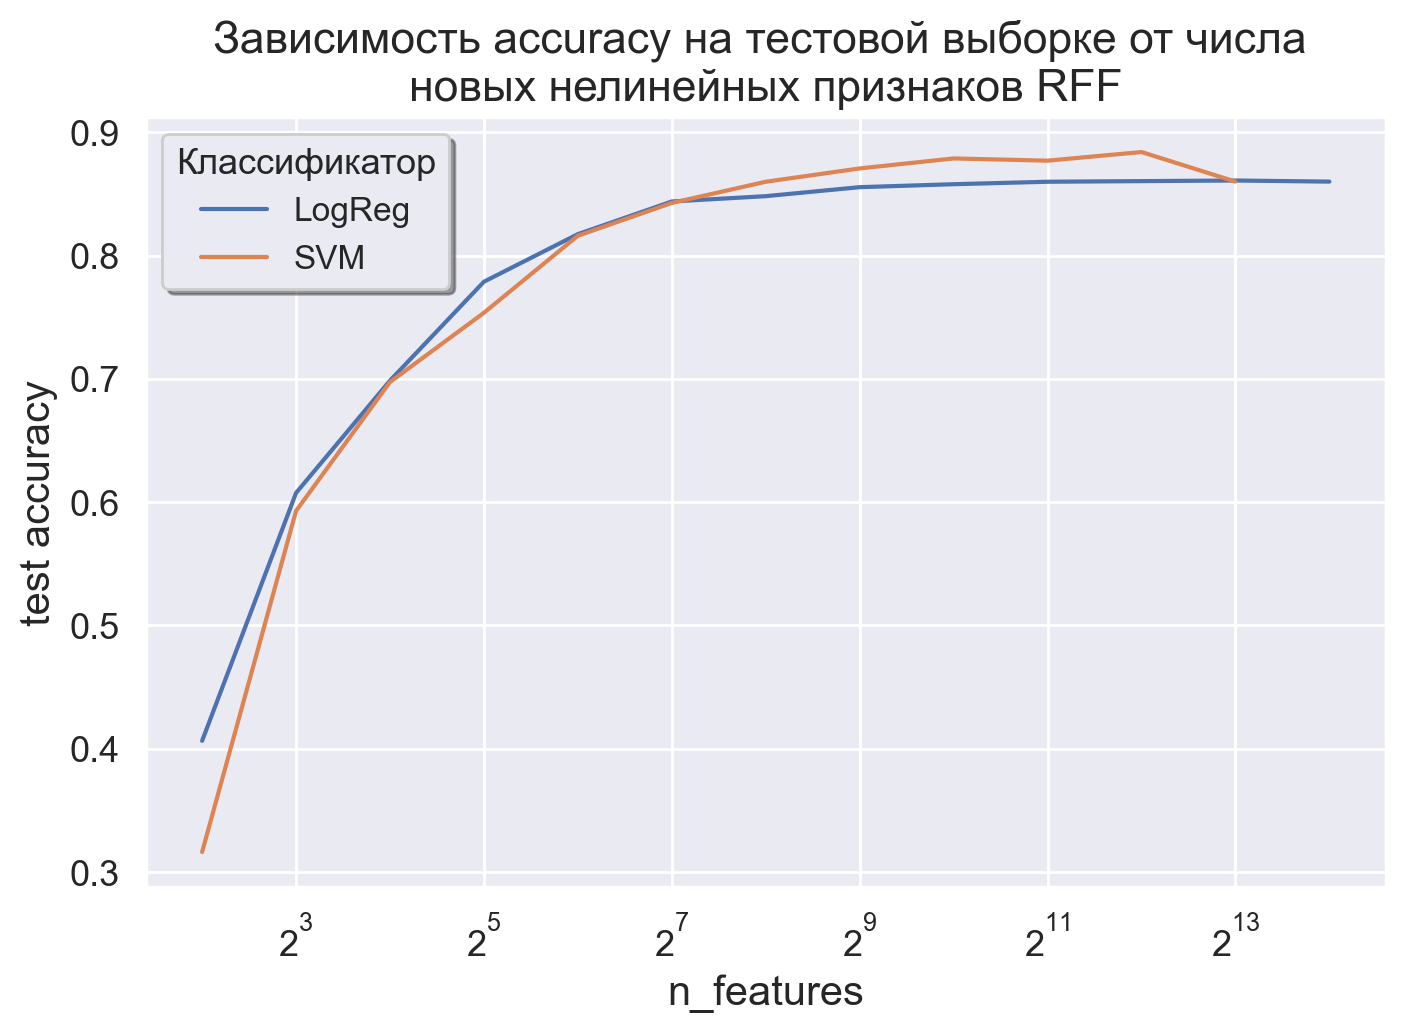

In [90]:
plt.plot(n_features, acc_test_logreg, label='LogReg')
plt.plot(n_features[:-1], acc_test_svm, label='SVM')

plt.title('Зависимость accuracy на тестовой выборке от числа \nновых нелинейных признаков RFF', fontsize=16)

plt.xscale(LogScale(0, base=2))
plt.xlabel("n_features", fontsize=15)
plt.ylabel("test accuracy", fontsize=15)
plt.legend(title='Классификатор', title_fontsize=13, fontsize=12, ncol=1, loc='best', shadow=True)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13);

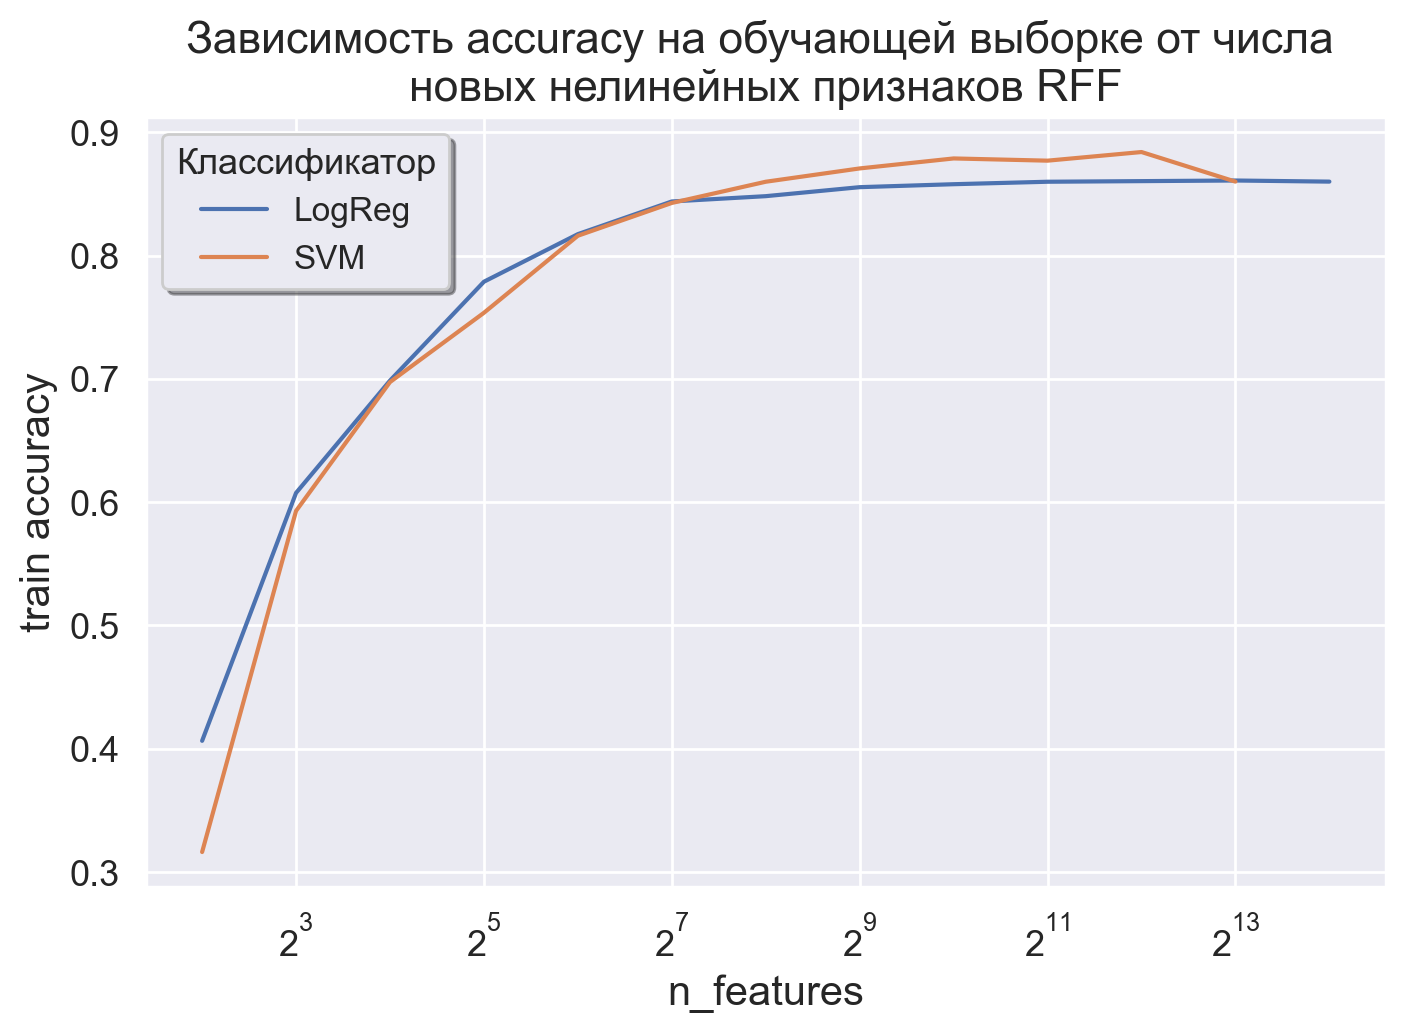

In [92]:
plt.plot(n_features, acc_test_logreg, label='LogReg')
plt.plot(n_features[:-1], acc_test_svm, label='SVM')

plt.title('Зависимость accuracy на обучающей выборке от числа \nновых нелинейных признаков RFF', fontsize=16)

plt.xscale(LogScale(0, base=2))
plt.xlabel("n_features", fontsize=15)
plt.ylabel("train accuracy", fontsize=15)
plt.legend(title='Классификатор', title_fontsize=13, fontsize=12, ncol=1, loc='best', shadow=True)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13);

**Вывод:** как видно, логистическая регрессия более явно выходит на плато около $accuracy = 0.86$ (это значение может быть выше при увеличении параметра `max_iter`, отвечающего за максимальное число итераций град. спуска (здесь использовалось значение по умолчанию 100)). Результаты линейного SVM немного колеблятся в районе 0.86-0.89, но, в целом, тоже близки к плато. Можно сказать, что это происходит примерно после $2^9$-$2^{10}$, т.е. 512-1024 новых признаков.

Также важно помнить, что, несмотря на то, что (в случае с SVM) можно получить улучшение сотых значений accuracy, взяв, к примеру, 8192 признаков, а не 1024, большое число признаков колоссально увеличивает скорость работы алгоритма и память, которую он требует. Поэтому взятие большого числа признаков можно ставить под сомнение по целому ряду причин.

*3. Важно ли, какую модель обучать — логистическую регрессию или SVM?*

Из графиков в предыдущем пункте видно, что при относительно маленьком числе новых признаков лучше себя показывает логистическая регрессия, а при большом (примерно больше $2^7 = 182$) — линейный SVM. Хотя в целом их результаты примерно одинаковы — различия очень малы. При этом важно, что логистическая регрессия всегда обучается и применяется быстрее SVM. К тому же, логистическая регрессия может показать результат, как минимум, не хуже линейного SVM, если увеличить ее максимальное число итераций (например, до 1000 со 100 по умолч. — см. пример ниже).

Для корректного сравнения **времени работы** алгоритмов выставим одинаковое макс. число итераций, а также зафиксируем сид. Для этого я немного обновлю класс, определенный в 1 задании:

In [7]:
class RFFPipeline_compare(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.pca = PCA(n_components=self.new_dim)
        
    def fit(self, X, y, train_mode=True):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.

        train_mode, bool: use strategy: train or test
        """
        if self.use_PCA:
            if train_mode:
                X = self.pca.fit_transform(X)
            else:
                X = self.pca.transform(X)
        else:
            self.new_dim = X.shape[1]

        if train_mode:
            # считаем сигму
            idx_1 = np.random.randint(0, y.shape[0], 1_000_000) # индексы для 1 части пар
            idx_2 = np.random.randint(0, y.shape[0], 1_000_000) # индексы для 2 части пар

            X_sub_1 = X[idx_1]  # подвыборка для 1 части пар
            X_sub_2 = X[idx_2]  # подвыборка для 2 части пар

            # считаем векторизованно
            self.sigma = np.sqrt(np.median(np.sum((X_sub_1 - X_sub_2) ** 2, axis=(1))))

            # генерируем наборы весов и сдвигов
            self.w = np.random.normal(0, (1/self.sigma), size=(self.n_features, self.new_dim))
            self.b = np.random.uniform(-np.pi, np.pi, size=self.n_features)
            
            # формируем новые признаки
            self.train_Random_Fourier_Features = np.cos(X@self.w.T + self.b)

            # обучение классификатора
            if self.classifier == 'logreg':
                self.classif = LogisticRegression(max_iter=1000, random_state=13, n_jobs=-1)  # по умолч. max_iter=100
            elif self.classifier == 'svm':
                # self.classif = SVC(kernel='linear', probability=True)
                self.classif = LinearSVC(max_iter=1000, random_state=13)                      # по умолч. max_iter=1000
            else:
                assert False, 'Указанный классификатор не поддерживается'
                
            self.classif.fit(self.train_Random_Fourier_Features, y)

        else:
            self.test_Random_Fourier_Features = np.cos(X@self.w.T + self.b)

        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        y_pred_proba = self.classif.predict_proba(X)  # чтобы метод работал, нужно поменять LinearSVC на SVC(kernel='linear', probability=True)

        return y_pred_proba
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        y_pred = self.classif.predict(X)
        
        return y_pred

In [101]:
from time import perf_counter
np.random.seed(13)

time_fit_logreg = []
time_infer_logreg = []
time_fit_svm = []
time_infer_svm = []

acc_train_logreg = []
acc_test_logreg = []
acc_train_svm = []
acc_test_svm = []
i = 0
k = 3

for _ in range(k):
    print(f'Итерация {i+1}')

    ### logreg

    rff = RFFPipeline_compare(classifier='logreg')
    # обучение
    start_time = perf_counter()
    rff.fit(x_train, y_train, train_mode=True)
    finish_time = perf_counter()
    delta_time = finish_time - start_time
    time_fit_logreg.append(delta_time)

    # применение
    start_time = perf_counter()
    y_pred_train = rff.predict(rff.train_Random_Fourier_Features)
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_train_logreg.append(acc_train)  # логируем

    rff.fit(x_test, y_test, train_mode=False)
    y_pred_test = rff.predict(rff.test_Random_Fourier_Features)
    acc_test = accuracy_score(y_test, y_pred_test)
    acc_test_logreg.append(acc_test)  # логируем
    finish_time = perf_counter()
    delta_time = finish_time - start_time
    time_infer_logreg.append(delta_time)

    ### SVM

    rff = RFFPipeline_compare(classifier='svm')
    # обучение
    start_time = perf_counter()
    rff.fit(x_train, y_train, train_mode=True)
    finish_time = perf_counter()
    delta_time = finish_time - start_time
    time_fit_svm.append(delta_time)

    # применение
    start_time = perf_counter()
    y_pred_train = rff.predict(rff.train_Random_Fourier_Features)
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_train_svm.append(acc_train)  # логируем

    rff.fit(x_test, y_test, train_mode=False)
    y_pred_test = rff.predict(rff.test_Random_Fourier_Features)
    acc_test = accuracy_score(y_test, y_pred_test)
    acc_test_svm.append(acc_test)  # логируем
    finish_time = perf_counter()
    delta_time = finish_time - start_time
    time_infer_svm.append(delta_time)

    i += 1

Итерация 1
Итерация 2
Итерация 3


In [102]:
# dataframe для сравнения 
df_compare = pd.DataFrame(columns=['Время обучения', 
                                   'Время применения',
                                   'Train Accuracy',
                                   'Test Accuracy'])

df_compare.loc['LogReg'] = [
    sum(time_fit_logreg) / k,
    sum(time_infer_logreg) / k,
    sum(acc_train_logreg) / k,
    sum(acc_test_logreg) / k
]

df_compare.loc['Linear SVM'] = [
    sum(time_fit_svm) / k,
    sum(time_infer_svm) / k,
    sum(acc_train_svm) / k,
    sum(acc_test_svm) / k
]

In [104]:
df_compare

Время обучения  Время применения  Train Accuracy  Test Accuracy
LogReg          222.802160          0.448560        0.912500       0.879300
Linear SVM      347.233817          0.405519        0.903367       0.869067

In [22]:
# обновим таблицу с общим сравнением, т.к. результаты выше более надежные: они получены по нескольким прогонам кода с фиксированным сидом
df_metrics.loc['LogReg']['PCA & RFF'] = 0.8793
df_metrics.loc['Linear SVM']['PCA & RFF'] = 0.8690

При гиперпараметрах по умолчанию и прочих равных **логистическая регрессия обучается быстрее и выдает лучшее качество** (на 0.01 в терминах accuracy), чем линейный SVM.
Возможно, раньше логистическая регрессия иногда показывала результат хуже, чем SVM при всех параметрах по умолчанию, поскольку у нее стояло ограничение на 100 итераций обучения, а у SVM — на 1000 — причем обе модели не сходились за это число итераций. Сейчас у обеих моделей было выставлено ограничение в 1000 итераций.

**Вывод:** использование **логистической регрессии** быстрее, чем линейного SVM, а также дает большее качество по метрике accuracy. Применяются модели одинаково быстро. *Можно утверждать, что использование логистической регрессии предпочтительнее.*

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

__Задание 5. (Максимум 2 балла)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

Мне сразу же пришла идея использовать в качестве классификатора **градиентный бустинг**, поскольку он обучается быстрее, чем все линейные классификаторы, которые были предложены здесь, и дает высокое качество. Можно будет сравнить эту реализацию с применением бустинга к сырым данным напрямую.

В начале проверим "на коленке", вставив в него уже посчитанные новые признаки напрямую:

In [106]:
model = CatBoostClassifier(task_type="GPU",
                           devices='0:1',
                           custom_loss='Accuracy')

model.fit(rff.train_Random_Fourier_Features,
          y_train,
          verbose=100,
          use_best_model=True,
          eval_set=(rff.test_Random_Fourier_Features, y_test),
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.15901
0:	learn: 1.7194018	test: 1.7251869	best: 1.7251869 (0)	total: 232ms	remaining: 3m 51s
100:	learn: 0.3475212	test: 0.4214590	best: 0.4214590 (100)	total: 14.5s	remaining: 2m 8s
200:	learn: 0.2840714	test: 0.3913279	best: 0.3913279 (200)	total: 27.6s	remaining: 1m 49s
300:	learn: 0.2465554	test: 0.3781927	best: 0.3781927 (300)	total: 40s	remaining: 1m 32s
400:	learn: 0.2221642	test: 0.3717296	best: 0.3717296 (400)	total: 52s	remaining: 1m 17s
500:	learn: 0.2003274	test: 0.3661843	best: 0.3661843 (500)	total: 1m 4s	remaining: 1m 3s
600:	learn: 0.1832370	test: 0.3631059	best: 0.3631059 (600)	total: 1m 15s	remaining: 50.4s
700:	learn: 0.1680872	test: 0.3604421	best: 0.3604421 (700)	total: 1m 27s	remaining: 37.4s
800:	learn: 0.1558673	test: 0.3594656	best: 0.3594643 (796)	total: 1m 39s	remaining: 24.7s
900:	learn: 0.1443010	test: 0.3582029	best: 0.3582029 (900)	total: 1m 51s	remaining: 12.3s
999:	learn: 0.1345835	test: 0.3576105	best: 0.3575708 (993)	total: 2m 3

In [107]:
# трейн
y_pred_train = model.predict(rff.train_Random_Fourier_Features)
acc_train = accuracy_score(y_train, y_pred_train)

# тест
y_pred_test = model.predict(rff.test_Random_Fourier_Features)
acc_test = accuracy_score(y_test, y_pred_test)

print(f'Качество на трейне составило: {round(acc_train, 4)}\
     \nКачество на тесте составило: {round(acc_test, 4)}')

Качество на трейне составило: 0.9718     
Качество на тесте составило: 0.8695


Теперь скорректирую **класс**, чтобы можно было поэксперементировать с `n_features` — возможно, бустинг проявит себя лучше, если взять большее или меньшее число новых признаков.

In [11]:
class RFFPipeline_GBM(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.pca = PCA(n_components=self.new_dim)
        self.model = CatBoostClassifier(task_type="GPU",
                                        devices='0:1',
                                        custom_loss='Accuracy')
        
    def fit(self, X, y, x_test, y_test):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.

        x_test, y_test are submitted for validation of GBM. They are not used in training directly.
        """
        if self.use_PCA:
            X = self.pca.fit_transform(X)
            x_test = self.pca.transform(x_test)
        else:
            self.new_dim = X.shape[1]

        
        # считаем сигму
        idx_1 = np.random.randint(0, y.shape[0], 1_000_000) # индексы для 1 части пар
        idx_2 = np.random.randint(0, y.shape[0], 1_000_000) # индексы для 2 части пар

        X_sub_1 = X[idx_1]  # подвыборка для 1 части пар
        X_sub_2 = X[idx_2]  # подвыборка для 2 части пар

        # считаем векторизованно
        self.sigma = np.sqrt(np.median(np.sum((X_sub_1 - X_sub_2) ** 2, axis=(1))))

        # генерируем наборы весов и сдвигов
        self.w = np.random.normal(0, (1/self.sigma), size=(self.n_features, self.new_dim))
        self.b = np.random.uniform(-np.pi, np.pi, size=self.n_features)
        
        # формируем новые признаки для теста и трейна
        self.train_Random_Fourier_Features = np.cos(X@self.w.T + self.b)
        self.test_Random_Fourier_Features = np.cos(x_test@self.w.T + self.b)
        
        # обучение классификатора
        self.model.fit(self.train_Random_Fourier_Features,
                        y,
                        verbose=100,
                        use_best_model=True,
                        eval_set=(self.test_Random_Fourier_Features, y_test))

        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        y_pred_proba = self.model.predict_proba(X)

        return y_pred_proba
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        y_pred = self.model.predict(X)
        
        return y_pred

In [8]:
rff_gbm = RFFPipeline_GBM()  # по умолчанию 1000 новых признаков
rff_gbm.fit(x_train, y_train, x_test, y_test)

дошел
Learning rate set to 0.15901
0:	learn: 1.7351349	test: 1.7343812	best: 1.7343812 (0)	total: 144ms	remaining: 2m 24s
100:	learn: 0.3567333	test: 0.4278207	best: 0.4278207 (100)	total: 13.8s	remaining: 2m 2s
200:	learn: 0.2888546	test: 0.3931150	best: 0.3930942 (199)	total: 26.5s	remaining: 1m 45s
300:	learn: 0.2525668	test: 0.3800108	best: 0.3800108 (300)	total: 38.8s	remaining: 1m 30s
400:	learn: 0.2252419	test: 0.3729430	best: 0.3729430 (400)	total: 50.9s	remaining: 1m 16s
500:	learn: 0.2036890	test: 0.3690083	best: 0.3690083 (500)	total: 1m 2s	remaining: 1m 2s
600:	learn: 0.1853635	test: 0.3661596	best: 0.3660929 (597)	total: 1m 14s	remaining: 49.5s
700:	learn: 0.1699577	test: 0.3637782	best: 0.3635235 (680)	total: 1m 26s	remaining: 36.8s
800:	learn: 0.1563944	test: 0.3620752	best: 0.3618400 (785)	total: 1m 37s	remaining: 24.3s
900:	learn: 0.1454417	test: 0.3609335	best: 0.3609253 (899)	total: 1m 49s	remaining: 12s
999:	learn: 0.1352821	test: 0.3600875	best: 0.3600651 (983)	tot

RFFPipeline_GBM()

In [9]:
y_pred_train = rff_gbm.predict(rff_gbm.train_Random_Fourier_Features)
acc_train = accuracy_score(y_train, y_pred_train)

# обработка данных для теста
y_pred_test = rff_gbm.predict(rff_gbm.test_Random_Fourier_Features)
acc_test = accuracy_score(y_test, y_pred_test)

print(f'Качество на трейне составило: {round(acc_train, 4)} \
    \nКачество на тесте составило: {round(acc_test, 4)}')

Качество на трейне составило: 0.9709     
Качество на тесте составило: 0.8683


In [12]:
rff_gbm = RFFPipeline_GBM(n_features=512)
rff_gbm.fit(x_train, y_train, x_test, y_test)

Learning rate set to 0.15901
0:	learn: 1.7473480	test: 1.7513117	best: 1.7513117 (0)	total: 125ms	remaining: 2m 5s
100:	learn: 0.3573649	test: 0.4275750	best: 0.4275750 (100)	total: 7.96s	remaining: 1m 10s
200:	learn: 0.2899056	test: 0.3913068	best: 0.3913068 (200)	total: 15.2s	remaining: 1m
300:	learn: 0.2523191	test: 0.3779007	best: 0.3779007 (300)	total: 22.2s	remaining: 51.6s
400:	learn: 0.2253878	test: 0.3708231	best: 0.3708183 (397)	total: 29.1s	remaining: 43.4s
500:	learn: 0.2042357	test: 0.3659363	best: 0.3659275 (499)	total: 35.8s	remaining: 35.7s
600:	learn: 0.1874113	test: 0.3632257	best: 0.3632257 (600)	total: 42.4s	remaining: 28.2s
700:	learn: 0.1714320	test: 0.3608928	best: 0.3607809 (697)	total: 49.2s	remaining: 21s
800:	learn: 0.1567737	test: 0.3598935	best: 0.3598935 (800)	total: 56s	remaining: 13.9s
900:	learn: 0.1450583	test: 0.3593744	best: 0.3591706 (896)	total: 1m 2s	remaining: 6.89s
999:	learn: 0.1348090	test: 0.3596655	best: 0.3591706 (896)	total: 1m 9s	remainin

RFFPipeline_GBM(n_features=512)

In [13]:
y_pred_train = rff_gbm.predict(rff_gbm.train_Random_Fourier_Features)
acc_train = accuracy_score(y_train, y_pred_train)

# обработка данных для теста
y_pred_test = rff_gbm.predict(rff_gbm.test_Random_Fourier_Features)
acc_test = accuracy_score(y_test, y_pred_test)

print(f'Качество на трейне составило: {round(acc_train, 4)} \
    \nКачество на тесте составило: {round(acc_test, 4)}')

Качество на трейне составило: 0.9671     
Качество на тесте составило: 0.8677


In [14]:
rff_gbm = RFFPipeline_GBM(n_features=2048)
rff_gbm.fit(x_train, y_train, x_test, y_test)

Learning rate set to 0.15901
0:	learn: 1.6749185	test: 1.6806682	best: 1.6806682 (0)	total: 381ms	remaining: 6m 20s
100:	learn: 0.3479555	test: 0.4205062	best: 0.4205062 (100)	total: 26.8s	remaining: 3m 58s
200:	learn: 0.2819692	test: 0.3874312	best: 0.3874312 (200)	total: 51.7s	remaining: 3m 25s
300:	learn: 0.2461025	test: 0.3738181	best: 0.3738181 (300)	total: 1m 15s	remaining: 2m 54s
400:	learn: 0.2195756	test: 0.3663046	best: 0.3663046 (400)	total: 1m 37s	remaining: 2m 26s
500:	learn: 0.1982927	test: 0.3627487	best: 0.3627487 (500)	total: 2m	remaining: 2m
600:	learn: 0.1826788	test: 0.3601127	best: 0.3599998 (594)	total: 2m 22s	remaining: 1m 34s
700:	learn: 0.1685167	test: 0.3589412	best: 0.3589393 (699)	total: 2m 44s	remaining: 1m 10s
800:	learn: 0.1559770	test: 0.3571496	best: 0.3570936 (787)	total: 3m 6s	remaining: 46.3s
900:	learn: 0.1447157	test: 0.3559366	best: 0.3559271 (899)	total: 3m 28s	remaining: 22.9s
999:	learn: 0.1344899	test: 0.3547936	best: 0.3547115 (960)	total: 3m

RFFPipeline_GBM(n_features=2048)

In [15]:
y_pred_train = rff_gbm.predict(rff_gbm.train_Random_Fourier_Features)
acc_train = accuracy_score(y_train, y_pred_train)

# обработка данных для теста
y_pred_test = rff_gbm.predict(rff_gbm.test_Random_Fourier_Features)
acc_test = accuracy_score(y_test, y_pred_test)

print(f'Качество на трейне составило: {round(acc_train, 4)} \
    \nКачество на тесте составило: {round(acc_test, 4)}')

Качество на трейне составило: 0.97     
Качество на тесте составило: 0.8688


В результате лучший вариант был с accuracy = 0.8695 со значениями по умолчанию (`n_features=1000`). Запишем это:

In [23]:
df_metrics.loc['CatBoostClassifier']['PCA & RFF'] = 0.8695
df_metrics

Исходные признаки     PCA     RFF  PCA & RFF
LogReg                         0.8320     NaN  0.8660     0.8793
Linear SVM                     0.7205     NaN  0.8561     0.8690
Kernel SVM                     0.8828     NaN     NaN        NaN
CatBoostClassifier                NaN  0.8792     NaN     0.8695

**Для сравнения:** градиентный бустинг на исходных признаках без PCA и RFF:

In [109]:
model = CatBoostClassifier(task_type="GPU",
                           devices='0:1',
                           custom_loss='Accuracy')

model.fit(x_train,
          y_train,
          verbose=100,
          use_best_model=True,
          eval_set=(x_test, y_test),
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.15901
0:	learn: 1.6907750	test: 1.6963500	best: 1.6963500 (0)	total: 179ms	remaining: 2m 58s
100:	learn: 0.3124170	test: 0.3721366	best: 0.3721366 (100)	total: 11.5s	remaining: 1m 42s
200:	learn: 0.2487538	test: 0.3320302	best: 0.3320302 (200)	total: 21.8s	remaining: 1m 26s
300:	learn: 0.2104278	test: 0.3146291	best: 0.3146291 (300)	total: 32s	remaining: 1m 14s
400:	learn: 0.1820920	test: 0.3028590	best: 0.3028590 (400)	total: 42.3s	remaining: 1m 3s
500:	learn: 0.1601843	test: 0.2948943	best: 0.2948740 (496)	total: 52.6s	remaining: 52.4s
600:	learn: 0.1417394	test: 0.2890786	best: 0.2889892 (599)	total: 1m 2s	remaining: 41.8s
700:	learn: 0.1257737	test: 0.2848832	best: 0.2848704 (699)	total: 1m 13s	remaining: 31.3s
800:	learn: 0.1126894	test: 0.2822864	best: 0.2822220 (798)	total: 1m 23s	remaining: 20.8s
900:	learn: 0.1013034	test: 0.2792264	best: 0.2792132 (898)	total: 1m 34s	remaining: 10.4s
999:	learn: 0.0920146	test: 0.2771889	best: 0.2771889 (999)	total: 1m 

In [110]:
# трейн
y_pred_train = model.predict(x_train)
acc_train = accuracy_score(y_train, y_pred_train)

# тест
y_pred_test = model.predict(x_test)
acc_test = accuracy_score(y_test, y_pred_test)

print(f'Качество на трейне составило: {round(acc_train, 4)}\
     \nКачество на тесте составило: {round(acc_test, 4)}')

Качество на трейне составило: 0.9843     
Качество на тесте составило: 0.8985


In [24]:
df_metrics.loc['CatBoostClassifier']['Исходные признаки'] = 0.8985
df_metrics

Исходные признаки     PCA     RFF  PCA & RFF
LogReg                         0.8320     NaN  0.8660     0.8793
Linear SVM                     0.7205     NaN  0.8561     0.8690
Kernel SVM                     0.8828     NaN     NaN        NaN
CatBoostClassifier             0.8985  0.8792     NaN     0.8695

**Итог:** *градиентный бустинг из CatBoost показал лучший результат среди всех реализаций:*
* $accuracy = 0.8985$ (лучший результат на тесте)
    * accuracy на трейне = 0.9843 — почти идеально
* время обучения = 3 мин. (лучший результат)
    * либо 20 сек. в случае с PCA и почти такое же качество, как у линейных моделей — в сравнении с 3-6 мин. обучения логистической регрессии и SVM
* время применения = 5 сек. (у линейных классификаторов около 0.5 сек., но у ядрового SVM почти 20 мин.)

*Однако при применении RFF все-таки лучше всего использовать более простую (линейную модель) в качестве классификатора.*

При этом, учитывая, что бустинг несколько переобучился, возможно, на исходных признаках можно получить еще лучшее качество на тесте, если грамотно подобрать гиперпараметры.